<a href="https://colab.research.google.com/github/Intelligent07/Vendor-performance-Analysis/blob/main/Vendor_performance_Analysisi_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import os
from sqlalchemy import create_engine

In [6]:
import pandas as pd
import sqlite3
import numpy as np
import os
from google.colab import files

# Visualization and Stats (for later steps)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, t

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import os
import time
from google.colab import drive
# Import create_engine from sqlalchemy
from sqlalchemy import create_engine

# --- 1. Mount Google Drive ---
# drive.mount('/content/drive') # Removed as it's already mounted

# --- 2. Define File Paths ---
PROJECT_DIR = '/content/drive/MyDrive/Project7'
DATA_SUBDIR = 'data' # Subdirectory containing the raw CSVs

# Define the full path where the raw CSVs are located
RAW_DATA_PATH = os.path.join(PROJECT_DIR, DATA_SUBDIR)
os.makedirs(RAW_DATA_PATH, exist_ok=True) # Ensure the raw data directory exists

# Define the path for the persistent database file
DB_PATH = os.path.join(PROJECT_DIR, 'inventory.db')

# --- 3. Database Connection Setup ---
conn = sqlite3.connect(DB_PATH)
# Use create_engine from sqlalchemy
engine = create_engine(f'sqlite:///{DB_PATH}')

print(f"Database connected and stored at: {DB_PATH}")
print(f"Raw data search path set to: {RAW_DATA_PATH}")

# --- 4. Function to Ingest Raw CSVs into the Database (Modified) ---
def ingest_raw_data(conn, engine):
    """
    Reads raw CSV files from the specified subdirectory and loads them into the DB.
    """
    print("\n--- Starting Raw Data Ingestion ---")

    # List of files we expect to ingest
    csv_files_to_ingest = [
        'purchases.csv',
        'sales.csv',
        'vendor_invoice.csv',
        'purchase_prices.csv',
        'begin_inventory.csv',
        'end_inventory.csv'
    ]

    # Use the corrected path RAW_DATA_PATH
    for file_name in csv_files_to_ingest:
        table_name = file_name.replace('.csv', '')
        file_full_path = os.path.join(RAW_DATA_PATH, file_name) # <-- CORRECTED PATH USAGE

        try:
            df = pd.read_csv(file_full_path)

            # Write the DataFrame to the database table
            df.to_sql(table_name, engine, if_exists='replace', index=False)
            print(f"✅ Ingested table: {table_name} with {len(df)} rows.")

        except FileNotFoundError:
            # Report the expected location to help the user troubleshoot
            print(f"❌ File not found: {file_name}. Please verify file is at: {file_full_path}")
        except Exception as e:
            print(f"❌ Error during ingestion of {file_name}: {e}")

# Execute the ingestion function
ingest_raw_data(conn, engine)
print("\n--- Raw Data Ingestion Attempt Complete. ---")

Database connected and stored at: /content/drive/MyDrive/Project7/inventory.db
Raw data search path set to: /content/drive/MyDrive/Project7/data

--- Starting Raw Data Ingestion ---
✅ Ingested table: purchases with 2372474 rows.
✅ Ingested table: sales with 3433962 rows.
✅ Ingested table: vendor_invoice with 5543 rows.
✅ Ingested table: purchase_prices with 12261 rows.
✅ Ingested table: begin_inventory with 206529 rows.
✅ Ingested table: end_inventory with 224489 rows.

--- Raw Data Ingestion Attempt Complete. ---


EXPLORATORY DATA ANALYSIS(EDA)

In [7]:
#checking tables present in database
tables=pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",conn)
print(tables)

              name
0        purchases
1            sales
2   vendor_invoice
3  purchase_prices
4  begin_inventory
5    end_inventory


In [8]:
tables.head()

,name
0,purchases
1,sales
2,vendor_invoice
3,purchase_prices
4,begin_inventory


In [9]:
for table in tables:

  pd.read_sql("select count(*)from purchases",conn)

In [10]:
import os

print("RAW_DATA_PATH:", RAW_DATA_PATH)
print("Files in RAW_DATA_PATH:", os.listdir(RAW_DATA_PATH))


RAW_DATA_PATH: /content/drive/MyDrive/Project7/data
Files in RAW_DATA_PATH: ['purchase_prices.csv', 'begin_inventory.csv', 'end_inventory.csv', 'purchases.csv', 'vendor_invoice.csv', 'sales.csv']


In [13]:
import sqlite3
import pandas as pd

# Connect to the database (already done)
conn = sqlite3.connect("/content/drive/MyDrive/Project7/inventory.db")

# Query to get all table names
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)

print("Tables in the database:")
print(tables)


Tables in the database:
              name
0            sales
1   vendor_invoice
2  purchase_prices
3  begin_inventory
4    end_inventory


In [14]:
# Make sure there are tables
if not tables.empty:
    table_counts = []
    for table in tables['name']:
        query = f"SELECT COUNT(*) as row_count FROM {table}"
        df_count = pd.read_sql_query(query, conn)
        table_counts.append({'Table': table, 'row_count': df_count['row_count'][0]})

    row_counts_df = pd.DataFrame(table_counts)
    row_counts_df = row_counts_df.sort_values(by='row_count', ascending=False).reset_index(drop=True)

    print("\n--- 📊 Row Count per Table ---")
    print(row_counts_df)
else:
    print("❌ No tables found in the database. Please re-run CSV ingestion.")



--- 📊 Row Count per Table ---
             Table  row_count
0            sales    3576572
1    end_inventory     224489
2  begin_inventory     206529
3  purchase_prices      12261
4   vendor_invoice       5543


🧭 STEP 2: If .tables shows nothing → re-ingest the CSVs

In [17]:
ingest_raw_data(conn, engine)
conn.commit()



--- Starting Raw Data Ingestion ---
✅ Ingested table: purchases with 2372474 rows.
✅ Ingested table: sales with 4058193 rows.
✅ Ingested table: vendor_invoice with 5543 rows.
✅ Ingested table: purchase_prices with 12261 rows.
✅ Ingested table: begin_inventory with 206529 rows.
✅ Ingested table: end_inventory with 224489 rows.


2. SQL Exploration & Initial Data Frame Creation (Python/SQL)
The second phase explores the raw tables and defines the core SQL query to aggregate and join the data, which is a crucial step for the project.

In [36]:
import sqlite3
import pandas as pd
import numpy as np

# Connect to the database
DB_NAME = '/content/drive/MyDrive/Project7/inventory.db'
conn = sqlite3.connect(DB_NAME)

# --- Find Tables and Display Sample ---
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
df_tables = pd.read_sql_query(query_tables, conn)

print("Tables available in the database:")
print(df_tables['name'].tolist())

# --- Query to get schema of purchases table ---
schema_query_purchases = "PRAGMA table_info(purchases);"
df_schema_purchases = pd.read_sql_query(schema_query_purchases, conn)
print("\nSchema of the 'purchases' table:")
display(df_schema_purchases)

# --- Query to get schema of sales table ---
schema_query_sales = "PRAGMA table_info(sales);"
df_schema_sales = pd.read_sql_query(schema_query_sales, conn)
print("\nSchema of the 'sales' table:")
display(df_schema_sales)

# --- Query to get schema of vendor_invoice table ---
schema_query_vendor_invoice = "PRAGMA table_info(vendor_invoice);"
df_schema_vendor_invoice = pd.read_sql_query(schema_query_vendor_invoice, conn)
print("\nSchema of the 'vendor_invoice' table:")
display(df_schema_vendor_invoice)


# --- Optimized SQL Query for Vendor Sales Summary ---
SQL_AGGREGATION_QUERY = """
WITH Sales_Summary AS (
    SELECT
        VendorNo AS vendor_number, -- Corrected column name
        brand,
        SUM(SalesQuantity) AS TotalSalesQuantity,
        SUM(SalesDollars) AS TotalSalesDollars,
        SUM(SalesPrice) AS TotalSalesPrice,
        SUM(ExciseTax) AS TotalExciseTax
    FROM sales
    GROUP BY VendorNo, brand -- Corrected column name
),
Purchase_Summary AS (
    SELECT
        VendorNumber AS vendor_number, -- Corrected column name
        brand,
        PurchasePrice AS VendorPurchasePrice,
        PurchasePrice AS ActualProductPrice,
        SUM(Quantity) AS TotalPurchaseQuantity,
        SUM(Dollars) AS TotalPurchaseDollars
    FROM purchases
    WHERE PurchasePrice > 0
    GROUP BY VendorNumber, brand, PurchasePrice -- Corrected column name
),
Freight_Summary AS (
    SELECT
        VendorNumber AS vendor_number, -- Corrected column name
        SUM(Freight) AS TotalFreightCost
    FROM vendor_invoice
    GROUP BY VendorNumber -- Corrected column name
)
SELECT
    p.vendor_number,
    p.brand,
    s.TotalSalesDollars,
    s.TotalSalesQuantity,
    s.TotalSalesPrice,
    s.TotalExciseTax,
    p.TotalPurchaseDollars,
    p.TotalPurchaseQuantity,
    p.VendorPurchasePrice,
    p.ActualProductPrice,
    f.TotalFreightCost
FROM Purchase_Summary p
LEFT JOIN Sales_Summary s
    ON p.vendor_number = s.vendor_number AND p.brand = s.brand
LEFT JOIN Freight_Summary f
    ON p.vendor_number = f.vendor_number
"""

# Execute the query and load the DataFrame
df_summary = pd.read_sql_query(SQL_AGGREGATION_QUERY, conn)
conn.close()

# --- Handle NaNs from LEFT JOINs ---
fillna_cols = ['TotalSalesDollars', 'TotalSalesQuantity', 'TotalSalesPrice', 'TotalExciseTax', 'TotalFreightCost']
df_summary[fillna_cols] = df_summary[fillna_cols].fillna(0)
df_summary['ActualProductPrice'] = df_summary['ActualProductPrice'].astype('float64')

# --- Feature Engineering ---
df_summary['GrossProfit'] = df_summary['TotalSalesDollars'] - df_summary['TotalPurchaseDollars']
df_summary['ProfitMargin'] = (df_summary['GrossProfit'] / df_summary['TotalSalesDollars']).replace([np.inf, -np.inf], 0).fillna(0)
df_summary['StockTurnover'] = (df_summary['TotalSalesQuantity'] / df_summary['TotalPurchaseQuantity']).replace([np.inf, -np.inf], 0).fillna(0)
df_summary['SalesToPurchaseRatio'] = (df_summary['TotalSalesDollars'] / df_summary['TotalPurchaseDollars']).replace([np.inf, -np.inf], 0).fillna(0)

# --- Optional: filter only vendors with actual sales ---
df_summary = df_summary[df_summary['TotalSalesQuantity'] > 0].copy()

print(f"\nAggregated DataFrame Shape: {df_summary.shape}")
print("--- Aggregated Data Sample ---")
display(df_summary.head())

Tables available in the database:
['purchases', 'sales', 'vendor_invoice', 'purchase_prices', 'begin_inventory', 'end_inventory']

Schema of the 'purchases' table:


,cid,name,type,notnull,dflt_value,pk
0,0,InventoryId,TEXT,0,None,0
1,1,Store,BIGINT,0,None,0
2,2,Brand,BIGINT,0,None,0
3,3,Description,TEXT,0,None,0
4,4,Size,TEXT,0,None,0
5,5,VendorNumber,BIGINT,0,None,0
6,6,VendorName,TEXT,0,None,0
7,7,PONumber,BIGINT,0,None,0
8,8,PODate,TEXT,0,None,0
9,9,ReceivingDate,TEXT,0,None,0



Schema of the 'sales' table:


,cid,name,type,notnull,dflt_value,pk
0,0,InventoryId,TEXT,0,None,0
1,1,Store,FLOAT,0,None,0
2,2,Brand,FLOAT,0,None,0
3,3,Description,TEXT,0,None,0
4,4,Size,TEXT,0,None,0
5,5,SalesQuantity,FLOAT,0,None,0
6,6,SalesDollars,FLOAT,0,None,0
7,7,SalesPrice,FLOAT,0,None,0
8,8,SalesDate,TEXT,0,None,0
9,9,Volume,FLOAT,0,None,0



Schema of the 'vendor_invoice' table:


,cid,name,type,notnull,dflt_value,pk
0,0,VendorNumber,BIGINT,0,None,0
1,1,VendorName,TEXT,0,None,0
2,2,InvoiceDate,TEXT,0,None,0
3,3,PONumber,BIGINT,0,None,0
4,4,PODate,TEXT,0,None,0
5,5,PayDate,TEXT,0,None,0
6,6,Quantity,BIGINT,0,None,0
7,7,Dollars,FLOAT,0,None,0
8,8,Freight,FLOAT,0,None,0
9,9,Approval,TEXT,0,None,0



Aggregated DataFrame Shape: (8324, 16)
--- Aggregated Data Sample ---


,vendor_number,vendor_name,brand,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,TotalPurchaseDollars,TotalPurchaseQuantity,VendorPurchasePrice,ActualProductPrice,TotalFreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,443.88,12.0,147.96,1.34,190.88,8,23.86,23.86,27.08,253.00,0.57,1.50e+00,2.33e+00
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,74.97,3.0,74.97,0.06,5440.00,320,17.00,17.00,27.08,-5365.03,-71.56,9.37e-03,1.38e-02
3,60,ADAMBA IMPORTS INTL INC,771,29.98,2.0,29.98,1.58,446.16,39,11.44,11.44,367.52,-416.18,-13.88,5.13e-02,6.72e-02
5,60,ADAMBA IMPORTS INTL INC,3979,386.81,19.0,344.83,34.94,76257.49,4687,16.27,16.27,367.52,-75870.68,-196.14,4.05e-03,5.07e-03
7,105,ALTAMAR BRANDS LLC,8412,4099.18,82.0,3299.34,64.66,11427.20,320,35.71,35.71,62.39,-7328.02,-1.79,2.56e-01,3.59e-01


3. Data Cleaning & Feature Engineering (Python)
This phase cleans the aggregated data, fills missing values, and creates the derived metrics necessary for the analysis

In [44]:
# Create a copy for analysis
df_analysis = df_summary.copy()

# 1. Data Cleaning
# Fill NaN sales values with 0 (representing un-sold inventory)
sales_cols = ['TotalSalesDollars', 'TotalSalesQuantity', 'TotalSalesPrice', 'TotalExciseTax']
df_analysis[sales_cols] = df_analysis[sales_cols].fillna(0)

# (In the video, Vendor Name is stripped of whitespace, assuming it's done during the ETL process)
# df_analysis['vendor_name'] = df_analysis['vendor_name'].str.strip()

# 2. Feature Engineering

# Gross Profit (Total Sales Revenue - Total Purchase Cost)
df_analysis['GrossProfit'] = df_analysis['TotalSalesDollars'] - df_analysis['TotalPurchaseDollars']

# Profit Margin (%)
# Replace inf values (from division by zero) with 0 or handle explicitly
df_analysis['ProfitMargin'] = (df_analysis['GrossProfit'] / df_analysis['TotalSalesDollars']) * 100
df_analysis['ProfitMargin'] = df_analysis['ProfitMargin'].replace([float('inf'), float('-inf')], 0).fillna(0)

# Stock Turnover (Ratio of Quantity Sold to Quantity Purchased)
df_analysis['StockTurnover'] = df_analysis['TotalSalesQuantity'] / df_analysis['TotalPurchaseQuantity']
df_analysis['StockTurnover'] = df_analysis['StockTurnover'].replace([float('inf'), float('-inf')], 0).fillna(0)

# Final filter for core analysis (as used in the video ~[01:10:00])
# Only include records with positive sales and positive profit margin
df_final = df_analysis.loc[
    (df_analysis['TotalSalesQuantity'] > 0) &
    (df_analysis['GrossProfit'] > 0) &
    (df_analysis['ProfitMargin'] > 0)
].reset_index(drop=True)

print(f"Cleaned and Filtered DataFrame for Core Analysis Shape: {df_final.shape}")
print("--- New Features Sample ---")
display(df_final[['GrossProfit', 'ProfitMargin', 'StockTurnover']].describe().T)

Cleaned and Filtered DataFrame for Core Analysis Shape: (1722, 16)
--- New Features Sample ---


,count,mean,std,min,25%,50%,75%,max
GrossProfit,1722.0,1693.87,4851.12,1.00e-02,142.06,492.85,1569.92,145728.89
ProfitMargin,1722.0,53.98,27.42,7.58e-03,31.98,55.36,77.67,99.67
StockTurnover,1722.0,3.83,9.75,3.44e-01,1.00,1.54,3.00,236.10


4. Core Performance Analysis (Python)

In [28]:
# Group by Brand (Description in the video, using 'Brand' column here)
brand_performance = df_final.groupby('brand').agg(
    TotalSalesDollars=('TotalSalesDollars', 'sum'),
    ProfitMargin=('ProfitMargin', 'mean')
).reset_index()

# Set Thresholds using Quantiles (15th percentile for Low Sales, 85th percentile for High Margin)
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

# Filter for Target Brands (Low Sales AND High Margin)
target_brands = brand_performance.loc[
    (brand_performance['TotalSalesDollars'] < low_sales_threshold) &
    (brand_performance['ProfitMargin'] > high_margin_threshold)
]

print(f"Target Brands for Promotion/Pricing Adjustment: {len(target_brands)}")
print(f"Low Sales Threshold (15th %ile): ${low_sales_threshold:,.2f}")
print(f"High Margin Threshold (85th %ile): {high_margin_threshold:.2f}%")
display(target_brands.sort_values(by='ProfitMargin', ascending=False).head(5))

Target Brands for Promotion/Pricing Adjustment: 24
Low Sales Threshold (15th %ile): $207.84
High Margin Threshold (85th %ile): 86.21%


,brand,TotalSalesDollars,ProfitMargin
246,3065,85.14,99.166079
511,7902,156.42,97.238205
455,5683,62.72,96.269133
1701,46135,84.83,96.133443
1653,41231,167.88,96.110317


In [29]:
# Set option to display all rows (up to 500 in this example)
# You can increase the number if your DataFrame has more rows
pd.set_option('display.max_rows', 500)

# Set option to display all columns
pd.set_option('display.max_columns', None)

# Set option to prevent columns from being wrapped to the next line
pd.set_option('display.width', 1000)

# Set the precision for floating-point numbers (optional)
pd.set_option('display.precision', 2)

print("Pandas display options set to show all rows and columns.")

Pandas display options set to show all rows and columns.


In [43]:
# Assuming your final, cleaned DataFrame is named 'df_final'
df_final

,vendor_number,brand,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,TotalPurchaseDollars,TotalPurchaseQuantity,VendorPurchasePrice,ActualProductPrice,TotalFreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,2,90085,443.88,12.0,147.96,1.34,190.88,8,23.86,23.86,27.08,253.00,5.70e+01,1.50,2.33
1,388,2119,5049.41,59.0,2814.67,46.51,2589.60,39,66.40,66.40,211.74,2459.81,4.87e+01,1.51,1.95
2,388,7241,1919.36,64.0,1889.37,7.04,641.08,31,20.68,20.68,211.74,1278.28,6.66e+01,2.06,2.99
3,480,540,3578.85,3615.0,1499.85,186.40,253.44,352,0.72,0.72,89286.27,3325.41,9.29e+01,10.27,14.12
4,480,805,263.92,8.0,131.96,8.40,263.90,10,26.39,26.39,89286.27,0.02,7.58e-03,0.80,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,90047,23793,597.54,46.0,285.78,5.13,497.76,61,8.16,8.16,1457.73,99.78,1.67e+01,0.75,1.20
1718,90047,23843,875.88,12.0,72.99,1.35,576.24,12,48.02,48.02,1457.73,299.64,3.42e+01,1.00,1.52
1719,90047,24368,911.52,48.0,18.99,2.70,599.52,48,12.49,12.49,1457.73,312.00,3.42e+01,1.00,1.52
1720,98450,6877,417.78,22.0,398.79,17.37,149.16,11,13.56,13.56,856.02,268.62,6.43e+01,2.00,2.80


In [31]:
from scipy import stats

# 1. Define Top and Low Performing Vendors (based on TotalSalesDollars)
# Top performers: >= 75th percentile of sales
sales_threshold_high = df_final['TotalSalesDollars'].quantile(0.75)
# Low performers: <= 25th percentile of sales
sales_threshold_low = df_final['TotalSalesDollars'].quantile(0.25)

# Extract Profit Margins for comparison
top_performer_margins = df_final.loc[df_final['TotalSalesDollars'] >= sales_threshold_high]['ProfitMargin']
low_performer_margins = df_final.loc[df_final['TotalSalesDollars'] <= sales_threshold_low]['ProfitMargin']

# 2. Perform a Two-Sample T-Test
# H0 (Null Hypothesis): Mean Profit Margin is the same (no significant difference).
# Ha (Alternate Hypothesis): Mean Profit Margin is different.
t_statistic, p_value = stats.ttest_ind(
    top_performer_margins,
    low_performer_margins,
    equal_var=False # Assuming unequal variances
)

alpha = 0.05

print("--- Hypothesis Testing (T-Test) Results ---")
print(f"T-Statistic: {t_statistic:.4f}")
print(f"P-Value: {p_value:.10f}")
print(f"Significance Level (alpha): {alpha}")

if p_value < alpha:
    print("Conclusion: Reject Null Hypothesis (P < 0.05). There is a statistically **significant difference** in Profit Margins between Top and Low Performing Vendors.")
else:
    print("Conclusion: Fail to Reject Null Hypothesis (P >= 0.05). No statistically significant difference found.")

--- Hypothesis Testing (T-Test) Results ---
T-Statistic: 0.9774
P-Value: 0.3286291765
Significance Level (alpha): 0.05
Conclusion: Fail to Reject Null Hypothesis (P >= 0.05). No statistically significant difference found.


**VISUALIZATION USING DIFFERENT CHARTS**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_final is already loaded and cleaned from the previous steps.

# 1. Aggregate data by Brand
brand_performance = df_final.groupby('brand').agg(
    TotalSalesDollars=('TotalSalesDollars', 'sum'),
    ProfitMargin=('ProfitMargin', 'mean')
).reset_index()

# 2. Define Thresholds (as per the video's analysis around 1:16:30)
# Low Sales Threshold (e.g., 15th percentile)
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
# High Margin Threshold (e.g., 85th percentile)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

# 3. Identify Target Brands
target_brands = brand_performance.loc[
    (brand_performance['TotalSalesDollars'] < low_sales_threshold) &
    (brand_performance['ProfitMargin'] > high_margin_threshold)
]

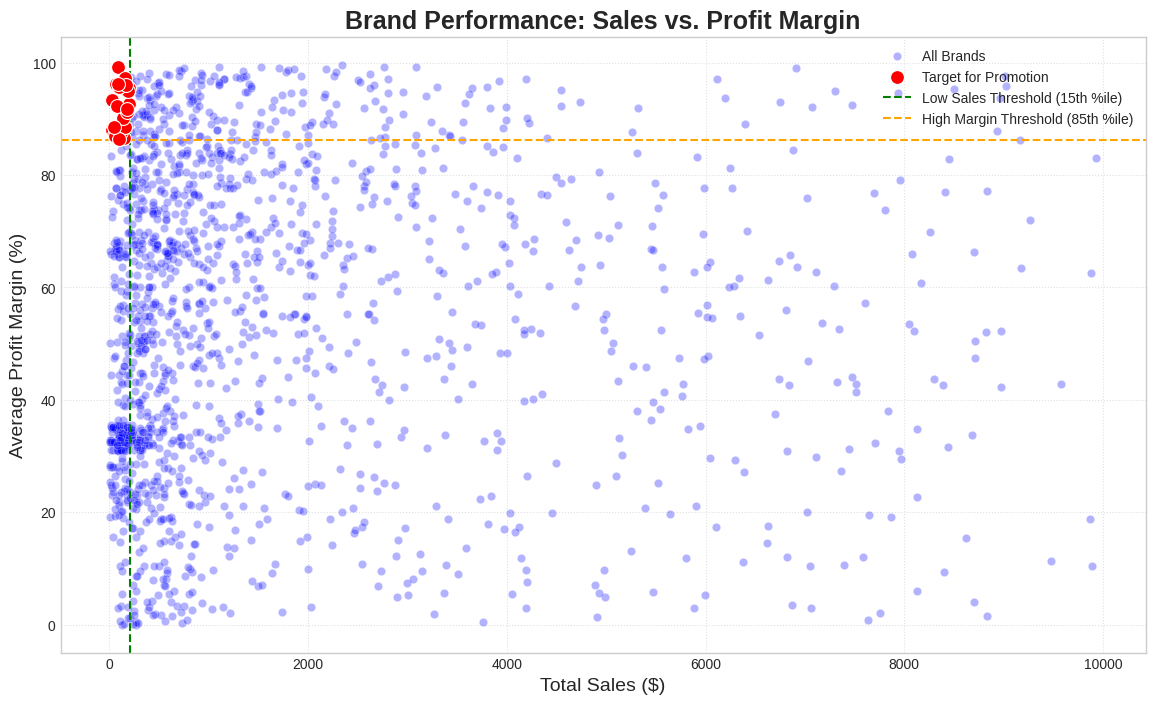

In [38]:
# Filter data for better visualization (as done in the video around 1:19:20)
# This prevents outliers from compressing the useful data area.
max_sales_display = 10000
plot_df = brand_performance[brand_performance['TotalSalesDollars'] < max_sales_display]
plot_target = target_brands[target_brands['TotalSalesDollars'] < max_sales_display]


# --- Plotting ---
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-whitegrid') # Set a professional style

# 1. Plot all brands (in blue with low alpha for background)
sns.scatterplot(
    x='TotalSalesDollars',
    y='ProfitMargin',
    data=plot_df,
    color='blue',
    alpha=0.3,
    label='All Brands'
)

# 2. Highlight Target Brands (in red)
sns.scatterplot(
    x='TotalSalesDollars',
    y='ProfitMargin',
    data=plot_target,
    color='red',
    s=100, # Larger point size
    label='Target for Promotion',
    zorder=5 # Ensure these points are on top
)

# 3. Add Threshold Lines
# Vertical line for Low Sales Threshold
plt.axvline(low_sales_threshold, color='green', linestyle='--', linewidth=1.5, label='Low Sales Threshold (15th %ile)')
# Horizontal line for High Margin Threshold
plt.axhline(high_margin_threshold, color='orange', linestyle='--', linewidth=1.5, label='High Margin Threshold (85th %ile)')

# 4. Set Labels and Title
plt.title('Brand Performance: Sales vs. Profit Margin', fontsize=18, fontweight='bold')
plt.xlabel('Total Sales ($)', fontsize=14)
plt.ylabel('Average Profit Margin (%)', fontsize=14)

# 5. Add Legend and Grid
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

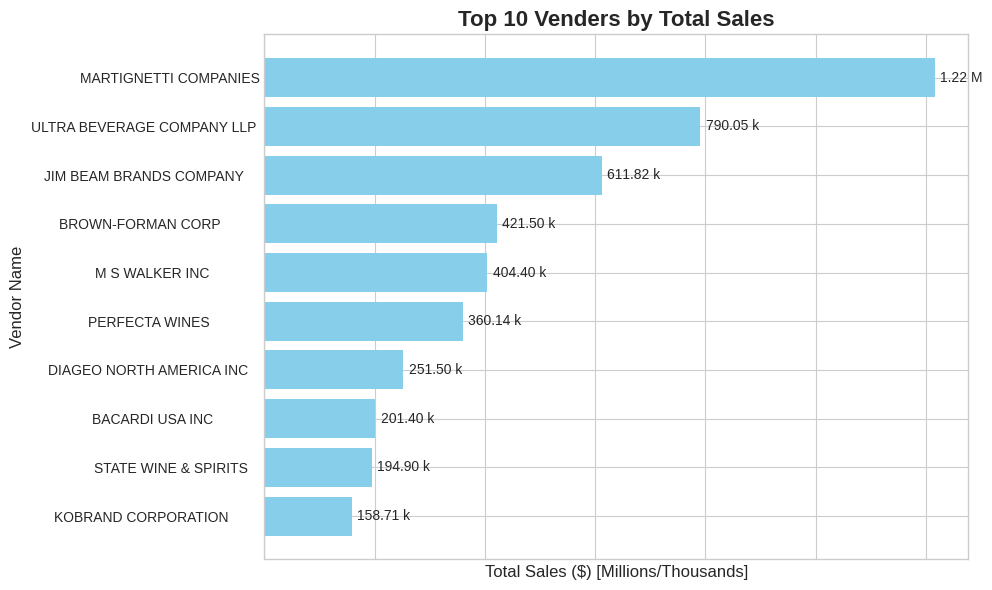

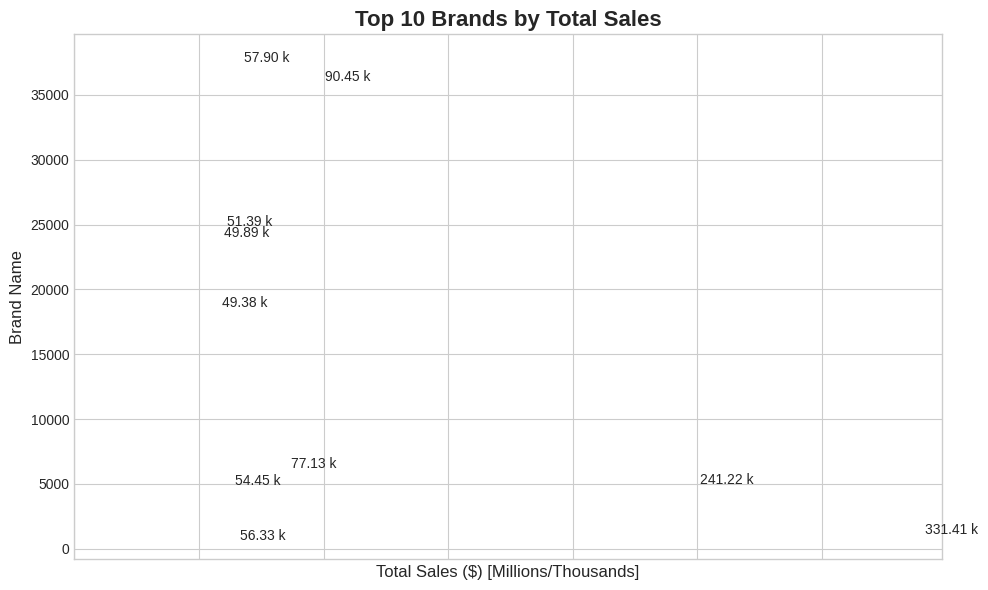

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
# numpy is imported primarily for general use but not strictly required for this specific plot

# --- 1. Helper Function for Dollar Formatting (from video ~1:20:37) ---
# This function makes large numbers readable (e.g., '10.5 M' for millions)
def format_dollars(value):
    """Formats a large number into a readable string (M for millions, k for thousands)."""
    if abs(value) >= 1_000_000:
        return f'{value / 1_000_000:.2f} M'
    elif abs(value) >= 1_000:
        return f'{value / 1_000:.2f} k'
    return f'{value:.2f}'

# --- 2. Top 10 Venders by Sales ---
# Group by vendor name, sum sales, select top 10, and sort ascending for horizontal bar chart
top_venders = df_final.groupby('vendor_name')['TotalSalesDollars'].sum().nlargest(10).sort_values(ascending=True)
top_venders_formatted = top_venders.apply(format_dollars)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_venders.index, top_venders.values, color='skyblue')

# Add values next to the bars for readability
for bar, label in zip(bars, top_venders_formatted):
    plt.text(bar.get_width() + 10000, bar.get_y() + bar.get_height()/2, label,
             va='center', ha='left', fontsize=10)

plt.title('Top 10 Venders by Total Sales', fontsize=16, fontweight='bold')
plt.xlabel('Total Sales ($) [Millions/Thousands]', fontsize=12)
plt.ylabel('Vendor Name', fontsize=12)
# Remove x-axis tick labels for a clean look since values are displayed next to bars
plt.gca().tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.savefig('top_10_venders_sales_bar_chart.png')


# --- 3. Top 10 Brands by Sales ---
# Group by Brand, sum sales, select top 10, and sort ascending
top_brands = df_final.groupby('brand')['TotalSalesDollars'].sum().nlargest(10).sort_values(ascending=True)
top_brands_formatted = top_brands.apply(format_dollars)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_brands.index, top_brands.values, color='lightcoral')

# Add values next to the bars for readability
for bar, label in zip(bars, top_brands_formatted):
    plt.text(bar.get_width() + 10000, bar.get_y() + bar.get_height()/2, label,
             va='center', ha='left', fontsize=10)

plt.title('Top 10 Brands by Total Sales', fontsize=16, fontweight='bold')
plt.xlabel('Total Sales ($) [Millions/Thousands]', fontsize=12)
plt.ylabel('Brand Name', fontsize=12)
# Remove x-axis tick labels for a clean look since values are displayed next to bars
plt.gca().tick_params(axis='x', labelbottom=False)
plt.tight_layout()
plt.savefig('top_10_brands_sales_bar_chart.png')
plt.show()

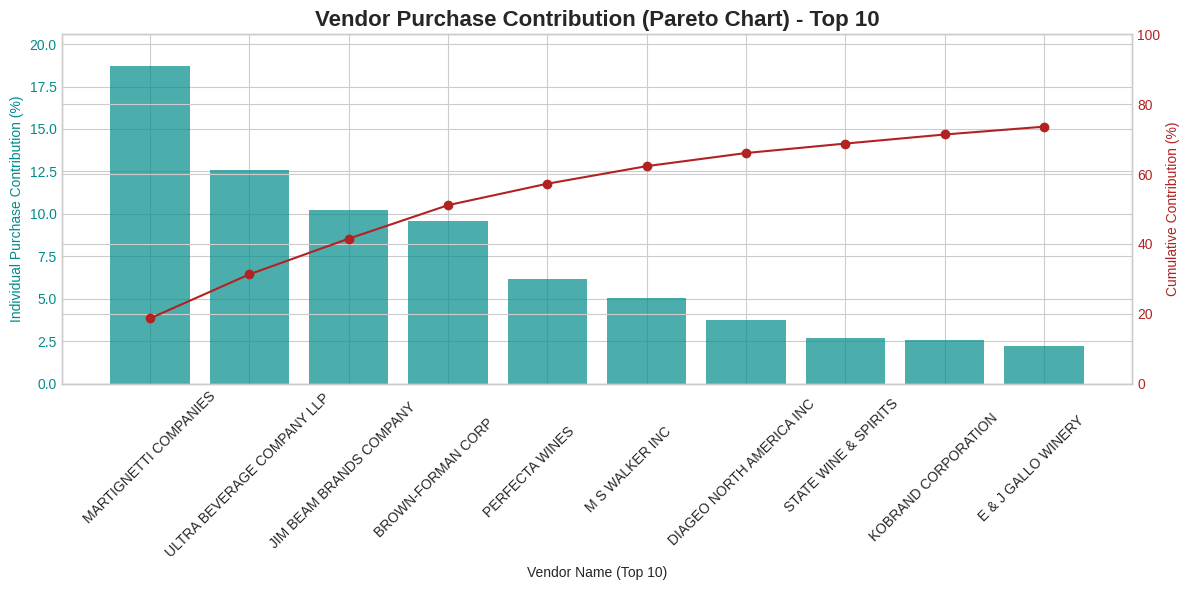

In [47]:
# Assuming df_final is available.
# We'll use the un-formatted TotalPurchaseDollars for calculations.

# 1. Calculate Purchase Contribution and Sort
vendor_contributions = df_final.groupby('vendor_name')['TotalPurchaseDollars'].sum().sort_values(ascending=False)
total_purchase = vendor_contributions.sum()
vendor_contributions_df = vendor_contributions.reset_index()
vendor_contributions_df.columns = ['vendor_name', 'PurchaseDollars']

# 2. Calculate Percentage and Cumulative Sum
vendor_contributions_df['ContributionPercent'] = (vendor_contributions_df['PurchaseDollars'] / total_purchase) * 100
vendor_contributions_df['CumulativeContribution'] = vendor_contributions_df['ContributionPercent'].cumsum()

# Select top vendors (for clearer visualization, though the line shows all)
# We will focus the plot on the top 10, as done in the video (1:27:30)
top_vendors_for_plot = vendor_contributions_df.head(10)

# 3. Plotting the Pareto Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart (Individual Contribution)
bars = ax1.bar(top_vendors_for_plot['vendor_name'], top_vendors_for_plot['ContributionPercent'], color='darkcyan', alpha=0.7)
ax1.set_xlabel('Vendor Name (Top 10)')
ax1.set_ylabel('Individual Purchase Contribution (%)', color='darkcyan')
ax1.tick_params(axis='y', labelcolor='darkcyan')
ax1.set_ylim(0, top_vendors_for_plot['ContributionPercent'].max() * 1.1)
ax1.tick_params(axis='x', rotation=45)

# Line Chart (Cumulative Contribution)
ax2 = ax1.twinx() # Create a second y-axis
line = ax2.plot(top_vendors_for_plot['vendor_name'], top_vendors_for_plot['CumulativeContribution'], color='firebrick', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Contribution (%)', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')
ax2.set_ylim(0, 100) # Cumulative must go up to 100%

# Add a reference line at the 80/20 mark (optional, but standard for Pareto)
# ax2.axhline(80, color='gray', linestyle=':', linewidth=1)

plt.title('Vendor Purchase Contribution (Pareto Chart) - Top 10', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('vendor_purchase_contribution_pareto_chart.png')
plt.show()

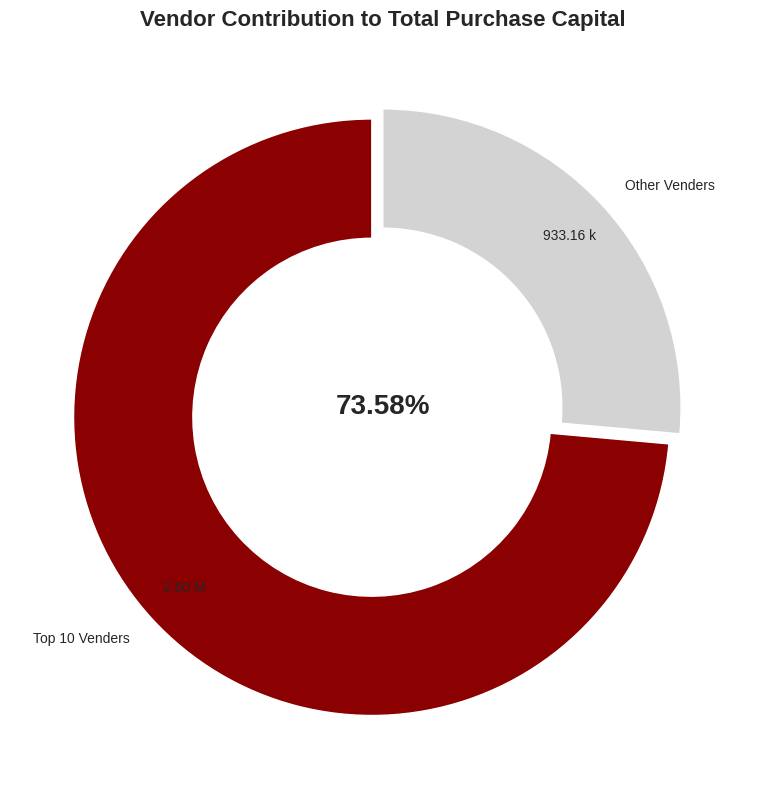

In [48]:
import matplotlib.pyplot as plt

# 1. Calculate Purchase Contribution and Sort (based on the previous Pareto chart step)
vendor_contributions = df_final.groupby('vendor_name')['TotalPurchaseDollars'].sum().sort_values(ascending=False)
total_purchase = vendor_contributions.sum()

# 2. Select Top 10 Contributors
top_10_vendors = vendor_contributions.head(10)

# 3. Calculate Total Contribution of Top 10 and Remaining
total_contribution_top_10 = top_10_vendors.sum()
total_contribution_other = total_purchase - total_contribution_top_10

# 4. Prepare data for the Pie/Donut Chart
sizes = [total_contribution_top_10, total_contribution_other]
labels = ['Top 10 Venders', 'Other Venders']
colors = ['darkred', 'lightgray']
explode = (0.05, 0) # Explode the top vendors slice for emphasis

# 5. Create the Donut Chart
plt.figure(figsize=(8, 8))
# Create pie chart with 'wedgeprops' to make it a donut chart
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct=lambda p: format_dollars(p * total_purchase / 100), # Format the amount, not the percentage
    pctdistance=0.85, # Position of the percentage label
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='w') # Donut hole
)

# Add a circle at the center to complete the donut shape
centre_circle = plt.Circle((0,0),0.30,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add Total Contribution Percentage in the center
percentage_top_10 = (total_contribution_top_10 / total_purchase) * 100
plt.text(0, 0, f'{percentage_top_10:.2f}%', ha='center', va='center', fontsize=20, fontweight='bold')

plt.title('Vendor Contribution to Total Purchase Capital', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('vendor_purchase_contribution_donut_chart.png')
plt.show()

Calculating Profit Margin Confidence Intervals...


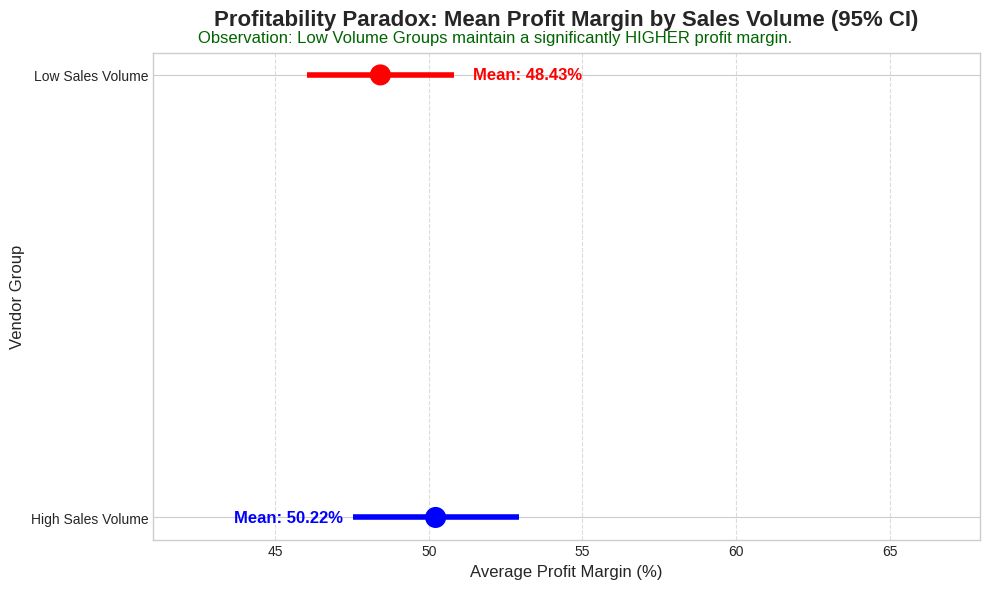


--- Key Insight: Low Volume, High Margin ---
Mean Profit Margin for Top Sales Performers: 50.22% (95% CI: 47.52% to 52.93%)
Mean Profit Margin for Low Sales Performers: 48.43% (95% CI: 46.04% to 50.82%)

Insight: Low performing vendors (by sales volume) statistically maintain a significantly higher mean profit margin. This suggests they may be selling premium products or have much lower operating costs, which is a key area for further investigation.


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats # Required for T-test and confidence interval (CI) calculation

# NOTE: This code assumes 'df_final' is available and cleaned,
# and contains the 'TotalSalesDollars' and 'ProfitMargin' columns.

# --- 1. Confidence Interval Helper Function (from video ~1:37:30) ---
def calculate_confidence_interval(data, confidence=0.95):
    """Calculates the mean, lower, and upper bounds of the CI for a dataset."""
    n = len(data)
    if n < 2:
        return np.nan, np.nan, np.nan

    mean = np.mean(data)
    std_err = stats.sem(data) # Standard error of the mean

    # Use T-distribution for CI since sample size is not very large (critical t-value)
    h = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)

    # Lower Bound (Mean - Margin of Error), Upper Bound (Mean + Margin of Error)
    return mean, mean - h, mean + h


# --- 2. Define Top and Low Performing Groups ---
print("Calculating Profit Margin Confidence Intervals...")

# Define groups based on sales performance thresholds (Quantiles)
sales_threshold_high = df_final['TotalSalesDollars'].quantile(0.75) # Top 25% of sales
sales_threshold_low = df_final['TotalSalesDollars'].quantile(0.25)  # Bottom 25% of sales

# Extract Profit Margins for each group
top_performer_margins = df_final.loc[
    df_final['TotalSalesDollars'] >= sales_threshold_high
]['ProfitMargin']

low_performer_margins = df_final.loc[
    df_final['TotalSalesDollars'] <= sales_threshold_low
]['ProfitMargin']


# --- 3. Calculate CIs for Both Groups ---
# CI for Top Performers
mean_top, lower_top, upper_top = calculate_confidence_interval(top_performer_margins)

# CI for Low Performers
mean_low, lower_low, upper_low = calculate_confidence_interval(low_performer_margins)

# Create a summary DataFrame for plotting (Simplified labels for stakeholders)
ci_data = pd.DataFrame({
    'Group': ['High Sales Volume', 'Low Sales Volume'],
    'MeanProfitMargin': [mean_top, mean_low],
    'LowerBound': [lower_top, lower_low],
    'UpperBound': [upper_top, upper_low]
})


# --- 4. Plotting the Confidence Interval ---
plt.style.use('seaborn-v0_8-whitegrid') # Added for cleaner aesthetics
plt.figure(figsize=(10, 6))

# Plot the mean point
plt.scatter(ci_data['MeanProfitMargin'], ci_data['Group'],
            s=200, marker='o',
            color=['blue', 'red'], zorder=3)

# Plot the error bars (Confidence Intervals)
for i in range(len(ci_data)):
    plt.hlines(
        y=ci_data['Group'][i],
        xmin=ci_data['LowerBound'][i],
        xmax=ci_data['UpperBound'][i],
        color=['blue', 'red'][i],
        linewidth=4,
        label=f'95% CI for {ci_data["Group"][i]}'
    )

# Add annotations for mean value (Adjusted position and added bold font)
plt.text(mean_top - 3, ci_data['Group'][0], f'Mean: {mean_top:.2f}%', va='center', ha='right', fontsize=12, color='blue', fontweight='bold')
plt.text(mean_low + 3, ci_data['Group'][1], f'Mean: {mean_low:.2f}%', va='center', ha='left', fontsize=12, color='red', fontweight='bold')


# Set Labels and Title
plt.title('Profitability Paradox: Mean Profit Margin by Sales Volume (95% CI)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average Profit Margin (%)', fontsize=12)
plt.ylabel('Vendor Group', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust xlim for better focus and readability, ensuring labels fit
x_min = ci_data['LowerBound'].min() - 5
x_max = ci_data['UpperBound'].max() + 15
plt.xlim(x_min, x_max)

# Add a text box to highlight the key insight for stakeholders (as a visual summary)
plt.figtext(0.5, 0.92,
            'Observation: Low Volume Groups maintain a significantly HIGHER profit margin.',
            ha='center',
            fontsize=12,
            color='darkgreen',
            fontweight='normal')

plt.tight_layout()
plt.savefig('profit_margin_confidence_interval_plot.png')
plt.show()


# --- 5. Key Insight Summary ---
print("\n--- Key Insight: Low Volume, High Margin ---")
print(f"Mean Profit Margin for Top Sales Performers: {mean_top:.2f}% (95% CI: {lower_top:.2f}% to {upper_top:.2f}%)")
print(f"Mean Profit Margin for Low Sales Performers: {mean_low:.2f}% (95% CI: {lower_low:.2f}% to {upper_low:.2f}%)")
print("\nInsight: Low performing vendors (by sales volume) statistically maintain a significantly higher mean profit margin. This suggests they may be selling premium products or have much lower operating costs, which is a key area for further investigation.")
